In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import dropna_pearsonr
from utils.df_preprocessing import monthly_climate_offset_and_clean

pd.options.mode.chained_assignment = None  # default='warn'

Load data:

In [4]:
from load_data import *

In [5]:
mon_ru = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
mon_en = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
mon_dict = {en:ru for en, ru in zip(mon_en, mon_ru)}

In [6]:
def compare_dfs(df1, df2):
    years = list(set(df1['Year']) & set(df2['Year']))
    min_y, max_y = years[0], years[-1]
    corrs = dict()

    for month in range(1,13):
        x_ = df1[(df1['Year']>=min_y) & (df1['Year']<=max_y)].iloc[:,month]
        y_ = df2[(df2['Year']>=min_y) & (df2['Year']<=max_y)].iloc[:,month]
        corrs[month] = dropna_pearsonr(x_, y_)
    
    return corrs

def compare_to_xlsx(df1, df2, name):
    corrs = pd.DataFrame(compare_dfs(df1, df2))
    corrs = corrs.transpose()
    corrs = corrs.rename(columns={0:'Корреляция', 1:'p-value'})
    wr = 'output/DF_Comparison.xlsx'
    try:
        with pd.ExcelWriter(wr, mode='a') as writer:
            corrs.to_excel(writer, sheet_name=name)
    except FileNotFoundError:
        corrs.to_excel(wr, sheet_name=name)

In [ ]:
compare_to_xlsx(grid_temp_C, mean_temp_C, 'Chok_Temp')
compare_to_xlsx(grid_prec_C, mean_prec_C, 'Chok_Prec')
compare_to_xlsx(grid_temp_H, mean_temp_H, 'Khat_Temp')
compare_to_xlsx(grid_prec_H, mean_prec_H, 'Khat_Prec')
compare_to_xlsx(grid_temp_I, mean_temp_I, 'Inuvik_Temp')
compare_to_xlsx(grid_prec_I, grid_prec_I, 'Inuvik_Prec')

In [8]:
def plot_mean_ds(df1, df2, title, l1, l2, ylim, ylabel='', xlabel='Year', ax=None):
    year_df1 = pd.DataFrame({'Year':df1['Year']})
    year_df2 = pd.DataFrame({'Year':df2['Year']})
    
    df1 = monthly_climate_offset_and_clean(df1).reset_index(drop=True)
    df2 = monthly_climate_offset_and_clean(df2).reset_index(drop=True)
    df1 = year_df1.join(df1.set_index('Year'), on='Year', how='left')
    df2 = year_df2.join(df2.set_index('Year'), on='Year', how='left')
    m1 = df1.iloc[:, range(1, 13)].mean(axis=1, skipna=True)
    m2 = df2.iloc[:, range(1, 13)].mean(axis=1, skipna=True)
    new_df1 = pd.DataFrame({'year':df1['Year'], 'mean1':m1})
    new_df2 = pd.DataFrame({'year':df2['Year'], 'mean2':m2})
    temp_df = new_df1.merge(new_df2, on='year')
    #print(temp_df.drop(['year'], axis=1).corr())
    r, p = dropna_pearsonr(temp_df['mean1'], temp_df['mean2'])
    if not ax:
        fig, ax = plt.subplots(figsize=(8,5))
        plt.subplots_adjust(right=0.9)
    
    ax.plot(df1['Year'], m1, label=l1)
    ax.plot(df2['Year'], m2, label=l2)
    ax.legend(frameon=False)
    if not ax:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_xlim([1900, 2021])
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel)
        plt.savefig(f'output/{title}_{ylabel}.png', dpi=100)
        plt.close(fig)
    print(f'{title}, {ylabel}, r={r:0.3f}, p={p:0.4f}')

Plot comparison:

Chokurdakh, Average temperature (°C), r=0.904, p=0.0000
Chokurdakh, Average precipitation (mm), r=0.217, p=0.1223
Chokurdakh, Average vapour pressure deficit (mbar), r=0.338, p=0.0040
Khatanga, Average temperature (°C), r=0.903, p=0.0000
Khatanga, Average precipitation (mm), r=0.906, p=0.0000
Khatanga, Average vapour pressure deficit (mbar), r=0.749, p=0.0000
Inuvik, Average temperature (°C), r=0.925, p=0.0000
Inuvik, Average precipitation (mm), r=0.653, p=0.0000
Inuvik, Average vapour pressure deficit (mbar), r=0.324, p=0.0117


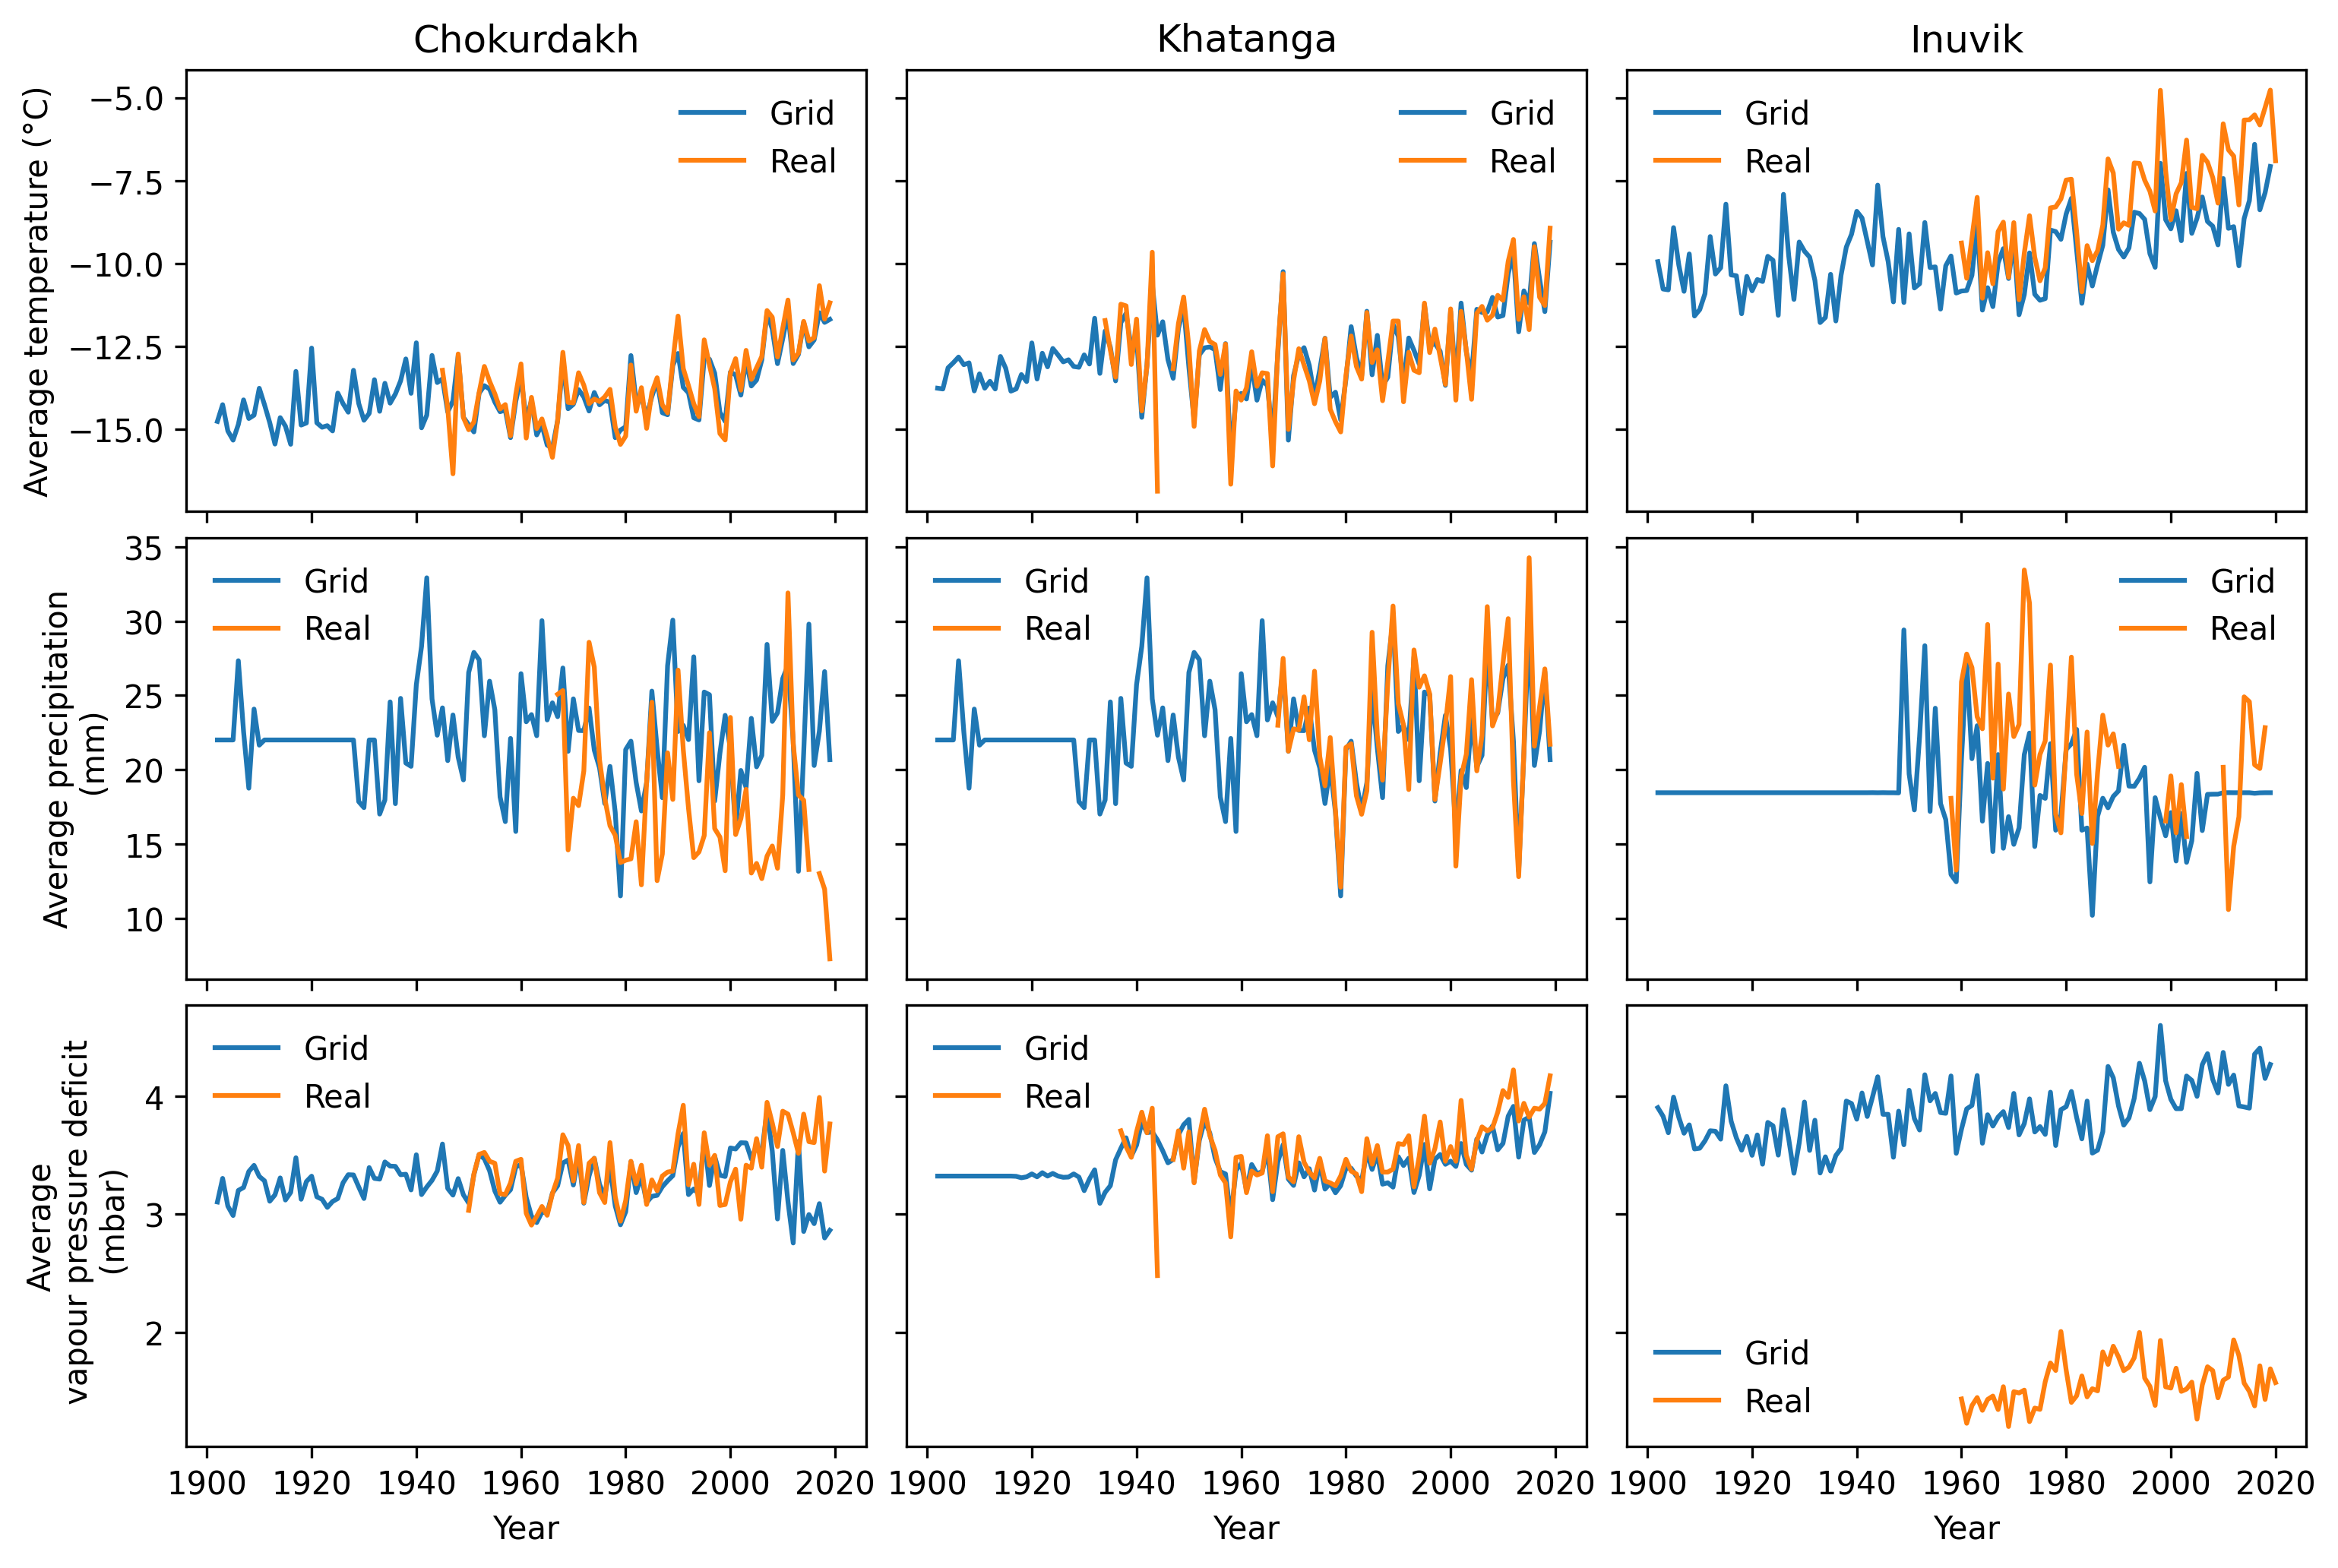

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey='row', dpi=300, figsize=(12, 8))
plt.subplots_adjust(hspace=0.06, wspace=0.06)
plot_mean_ds(grid_temp_C, mean_temp_C, 'Chokurdakh', 'Grid', 'Real', [-18, -4], 'Average temperature (°C)', ax=axes[0, 0])
plot_mean_ds(grid_prec_C, mean_prec_C, 'Chokurdakh', 'Grid', 'Real', [5, 40], 'Average precipitation (mm)', ax=axes[1, 0])
plot_mean_ds(grid_vp_C, mean_vpd_C, 'Chokurdakh', 'Grid', 'Real', [1,5],  'Average vapour pressure deficit (mbar)', ax=axes[2, 0])
plot_mean_ds(grid_temp_H, mean_temp_H, 'Khatanga', 'Grid', 'Real', [-18, -4], 'Average temperature (°C)', ax=axes[0, 1])
plot_mean_ds(grid_prec_H, mean_prec_H, 'Khatanga', 'Grid', 'Real', [5, 40], 'Average precipitation (mm)', ax=axes[1, 1])
plot_mean_ds(grid_vp_H, mean_vpd_H, 'Khatanga', 'Grid', 'Real', [1,5], 'Average vapour pressure deficit (mbar)', ax=axes[2, 1])
plot_mean_ds(grid_temp_I, mean_temp_I, 'Inuvik', 'Grid', 'Real', [-18, -4], 'Average temperature (°C)', ax=axes[0, 2])
plot_mean_ds(grid_prec_I, mean_prec_I, 'Inuvik', 'Grid', 'Real', [5, 40], 'Average precipitation (mm)', ax=axes[1, 2])
plot_mean_ds(grid_vp_I, mean_vpd_I, 'Inuvik', 'Grid', 'Real', [1,5], 'Average vapour pressure deficit (mbar)', ax=axes[2, 2])

axes[0, 0].set_title('Chokurdakh')
axes[0, 1].set_title('Khatanga')
axes[0, 2].set_title('Inuvik')

axes[0, 0].set_ylabel('Average temperature (°C)')
axes[1, 0].set_ylabel('Average precipitation\n (mm)')
axes[2, 0].set_ylabel('Average\n vapour pressure deficit\n (mbar)')
for i in range(3):
    axes[2, i].set_xlabel('Year')
plt.show()

In [ ]:
plt.savefig(f'output/Figure S1.png', dpi=300)
plt.close(fig)